In [1]:
import numpy as np
import pandas as pd
import sys
import os
from scipy.stats.mstats import winsorize
from sklearn import preprocessing
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
sys.path.append('/home/tianyuchuan/Desktop/AutoFormula')
from AutoTester import AutoTester, Stats
from AutoFormula_cy import AutoFormula_cy
from AutoFormula.FormulaTree_cy import FormulaTree, Node, FormulaParser
from AutoFormula.SignalGenerator_cy import SignalGenerator

In [2]:
data_path = '/home/tianyuchuan/Desktop/interval_data.csv'
data = pd.read_csv(data_path)

In [3]:
data.columns = ['trade_symbol','time','open','close','high','low','volume','vwap','adjustment','type']
data["hour"] = data["time"].apply(lambda x:int(x[11:13]))
data["minute"] = data["time"].apply(lambda x:int(x[14:16]))
data["date"] = data["time"].apply(lambda x:x[:10])

In [4]:
del_index = data[(data.hour == 9)&(data.minute == 30)].index
data = data.drop(del_index)

In [5]:
data = data[data.trade_symbol !=  905 ]
data = data[data.trade_symbol !=  300 ]
data = data[data.trade_symbol !=  16 ]

In [6]:
data_train = data[data.date < "2019-01-01"]
data_test = data[data.date >= "2019-01-01"]

In [7]:
data_source = data_train
formula_parser = FormulaParser()
auto= AutoFormula_cy(data_source)
tree = FormulaTree(4)

# test the performance of the autofeature

In [8]:
col = ["open","high","low","close","volume","vwap"]
for x in col:
    data_source[x] = data_source[x].astype(float)
data_source

,trade_symbol,time,open,close,high,low,volume,vwap,adjustment,type,hour,minute,date
185,600052,2018-01-02 09:35:00,3.78,3.79,3.79,3.77,257700.0,3.78,0.0,0,9,35,2018-01-02
186,600061,2018-01-02 09:35:00,13.22,13.20,13.26,13.18,120700.0,13.21,0.0,0,9,35,2018-01-02
187,600073,2018-01-02 09:35:00,8.16,8.14,8.17,8.11,216800.0,8.14,0.0,0,9,35,2018-01-02
188,600135,2018-01-02 09:35:00,10.89,10.90,10.94,10.86,58700.0,10.91,0.0,0,9,35,2018-01-02
189,600141,2018-01-02 09:35:00,16.93,16.89,16.95,16.85,171700.0,16.89,0.0,0,9,35,2018-01-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206171,300672,2018-12-28 15:00:00,36.42,36.31,36.42,36.32,28000.0,36.35,0.0,0,15,0,2018-12-28
2206172,300686,2018-12-28 15:00:00,10.98,11.03,11.03,10.98,207700.0,11.02,0.0,0,15,0,2018-12-28
2206173,300688,2018-12-28 15:00:00,40.10,39.90,40.10,39.89,122100.0,39.99,0.0,0,15,0,2018-12-28
2206174,300717,2018-12-28 15:00:00,14.37,14.34,14.39,14.33,42100.0,14.35,0.0,0,15,0,2018-12-28


In [9]:
def resample(data,freq):
    #data = data.loc[map(lambda x: x.hour != 9 or x.minute != 30, data.index)]
    new_index = data.index[freq-1 : : freq]
    new_data = pd.DataFrame([], index=new_index, columns=data.columns)
    for i in range(len(data)//freq):
        slice_ = data.iloc[freq*i : freq*(i+1)]
        trade_symbol_ = slice_['trade_symbol'][freq*(i+1)-1]
        time_ = slice_['time'][freq*(i+1)-1]
        open_ = slice_['open'][freq*i]
        close_ = slice_['close'][freq*(i+1)-1]
        high_ = slice_['high'].max()
        low_ = slice_['low'].min()
        volume_ = slice_['volume'].sum()
        vwap_ = slice_['vwap'][freq*(i+1)-1]
        adjustment_ = slice_['adjustment'][freq*(i+1)-1]
        type_ = slice_['type'][freq*(i+1)-1]
        hour_ = slice_['hour'][freq*(i+1)-1]
        minute_ = slice_['minute'][freq*(i+1)-1]
        date_ = slice_['date'][freq*(i+1)-1]
        new_data.iloc[i] = [trade_symbol_,time_,open_, close_, high_, low_ , volume_,vwap_,adjustment_,type_,hour_,minute_,date_]
    new_data['ret'] = new_data['close'] / new_data['open'] - 1
    new_data.index = range(len(new_data))
    return new_data

In [10]:
def make_columns(data_source):
    names = ['open','high','low','close','volume','vwap']
    stock_data = {name.capitalize(): [] for name in names}
    for name in names:
        stock_data[name.capitalize()].append(list(data_source[name]))
    for name in names:
        stock_data[name.capitalize()] = np.vstack(stock_data[name.capitalize()]).T
    return stock_data

In [11]:
def auto_feature(data,formula):
    stock_data = make_columns(data)
    signal = auto.cal_formula(formula,stock_data)
    return pd.DataFrame(signal).fillna(0)

In [12]:
rand_list = list(set(data_source.trade_symbol))
resampled_data =  []
for i in range(len(rand_list)):
    data_temp = data_source[data_source.trade_symbol == rand_list[i]]
    data_temp.index = range(len(data_temp))
    data_temp_48 = resample(data_temp, 48)
    data_temp_48.index  = data_temp_48.time
    resampled_data.append(data_temp_48)

In [13]:
formula_1 = "tsregres_2d{Close,High,26}"
formula_2 = "tshpf{minus_2d{High,Vwap},10,3}"
formula_3 = "add_2d{tsregres_2d{Vwap,High,17},tsfftimag{neg_2d{Low},19,17}}"

formula_temp_1 = formula_parser.parse(formula_1)
for i in range(len(resampled_data)):
        signal_dataframe = auto_feature(resampled_data[i],formula_temp_1)
        signal_dataframe.index = resampled_data[i].index
        resampled_data[i]['alpha01'] = signal_dataframe

formula_temp_2 = formula_parser.parse(formula_2)
for i in range(len(resampled_data)):
        signal_dataframe = auto_feature(resampled_data[i],formula_temp_2)
        signal_dataframe.index = resampled_data[i].index
        resampled_data[i]['alpha02'] = signal_dataframe

formula_temp_3 = formula_parser.parse(formula_3)
for i in range(len(resampled_data)):
        signal_dataframe = auto_feature(resampled_data[i],formula_temp_3)
        signal_dataframe.index = resampled_data[i].index
        resampled_data[i]['alpha03'] = signal_dataframe



df2 = pd.DataFrame()
for i in range(len(resampled_data)):
    df2 = pd.concat([df2,resampled_data[i]],axis=1)

alpha_set = []
for i in range(3):
    alpha = df2["alpha0"+str(i+1)]
    normalized_alpha = alpha.apply(lambda x: pd.Series(preprocessing.scale(winsorize(x,limits=[0.025, 0.025]))),axis =1)
    alpha_set.append(normalized_alpha)

alpha_set[0]

,0,1,2,3,4,5,6,7,8,9,...,188,189,190,191,192,193,194,195,196,197
time,,,,,,,,,,,,,,,,,,,,,
2018-01-02 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-03 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-04 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-05 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-08 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24 15:00:00,0.431195,0.170849,0.355647,-0.310505,-0.568330,1.128135,-3.105324,0.706680,0.660323,-0.590299,...,-0.255755,0.602470,-1.381907,0.303671,-0.185683,0.799579,0.688592,0.972086,0.620450,1.550998
2018-12-25 15:00:00,-0.951817,0.286187,1.098235,0.567503,-0.761276,0.281652,-2.843959,0.619394,0.688243,-0.364347,...,-0.344076,0.721296,-1.185746,0.530032,-0.282883,0.130803,1.061834,-0.005501,0.398489,0.056547
2018-12-26 15:00:00,3.141891,-0.375780,-0.317344,0.908878,0.726545,1.477458,-0.347128,-0.587164,-0.228452,-0.349772,...,0.276661,0.021413,0.192179,-0.264429,-0.044492,-0.206667,-0.041596,0.028688,-0.113161,-0.417060


# delete zdt 

In [14]:
zdt_list = df2["type"]

In [15]:
from math import nan
for x in range(len(zdt_list)):
    for y in range(len(zdt_list.iloc[x])):
        if zdt_list.iloc[x][y] == 1 or zdt_list.iloc[x][y] == -1:
            alpha_set[0].iloc[x][y]  = nan
            alpha_set[1].iloc[x][y]  = nan
            alpha_set[2].iloc[x][y]  = nan
    

# in-sample test

alpha1 最大回撤： -0.07591136741360871
alpha1 年化收益率 0.5641724019796539
alpha1 Sharpe ratio 3.2814184010847653
alpha2 最大回撤： -0.08404310695607664
alpha2 年化收益率 0.5472685054491309
alpha2 Sharpe ratio 3.287462202232475
alpha3 最大回撤： -0.07280245518884676
alpha3 年化收益率 0.48499875648200885
alpha3 Sharpe ratio 2.9465076963298054


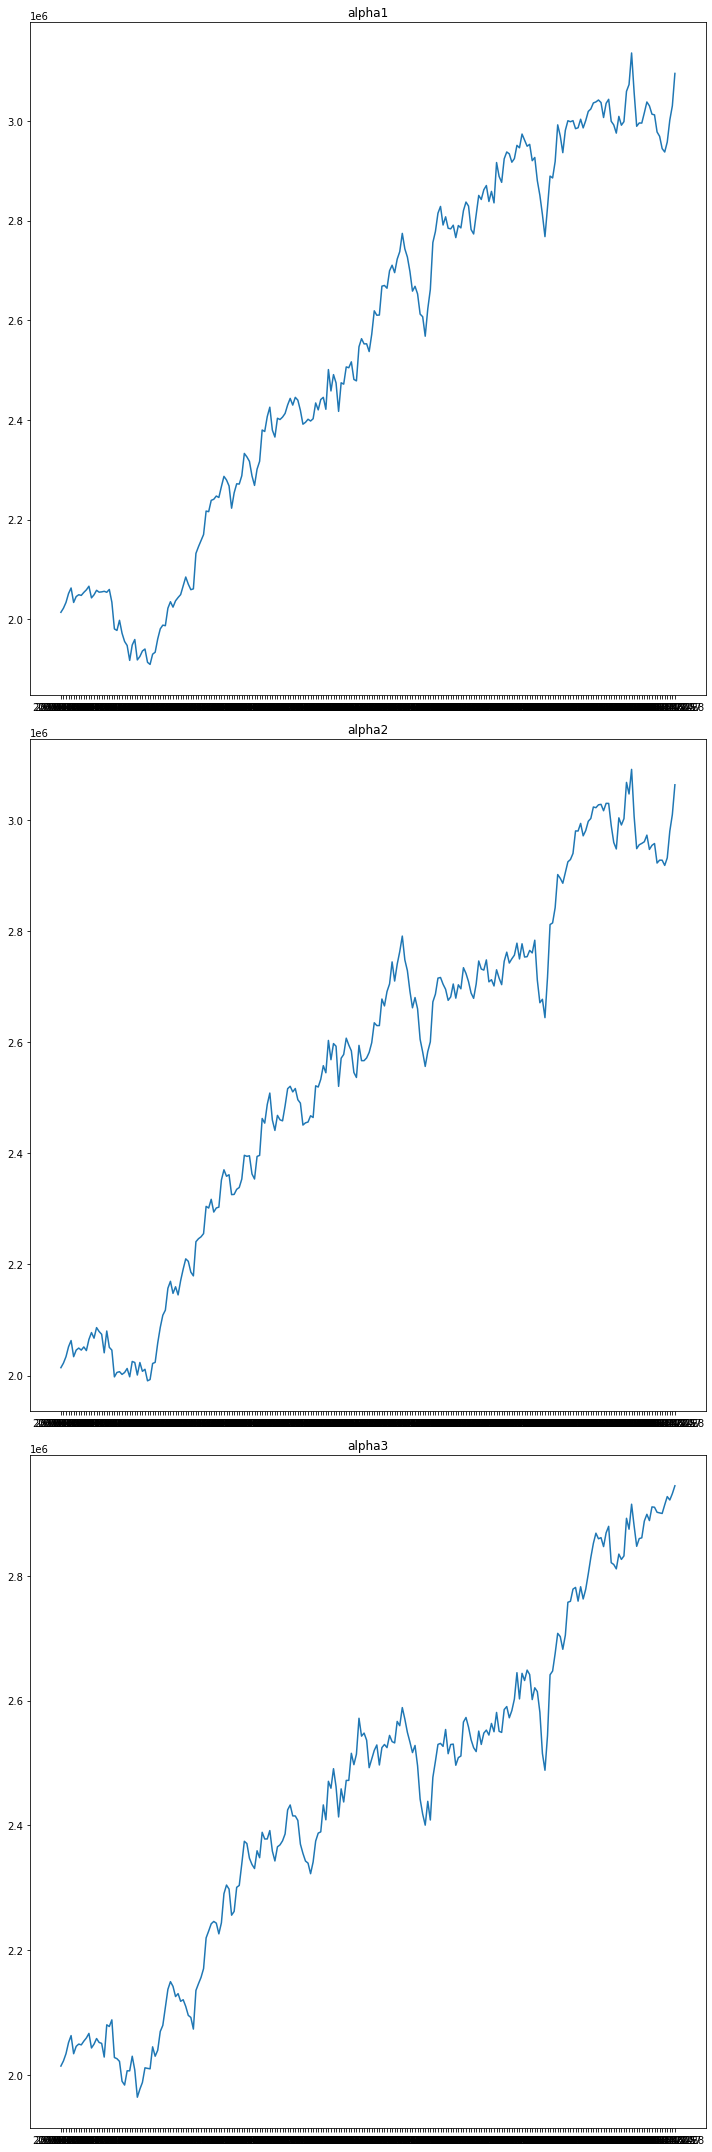

In [20]:
#control the daily turnover in 200%
fig, ax = plt.subplots(3, 1, figsize = (10,30))
list1 = [0,1,2]
for l in range(3):
    k = list1[l]
    money = 1000000
    num = 10
    rate = 0.0015
    pos = []
    index1 = []
    for i in alpha_set[k].index[1:]:
        if int(i[11:13]) == 15 and int(i[14:16]) == 0:
            index1.append(i[:10])
    portfolio = pd.Series(index = index1)
    df_ret=df2['ret'].copy().fillna(0)
    for i in range(198):
        pos.append(money/198)
    for i in alpha_set[k].index[1:]:
        money = 0
        profit = 0

        pre_pos = []
        cur_pos = []


        index_list = list(alpha_set[0].index)
        index_value = index_list.index(i)

        rank_previous=alpha_set[k].iloc[index_value-1].dropna().sort_values()
        for j in range(num):
            pre_pos.append(rank_previous.index[j])
        for j in range(1,num+1):
            pre_pos.append(rank_previous.index[-j])

        rank_current=alpha_set[k].loc[i].dropna().sort_values()
        for j in range(num):
            cur_pos.append(rank_current.index[j])
        for j in range(1,num+1):
            cur_pos.append(rank_current.index[-j])

        inter_num = len(list(set(cur_pos) & set(pre_pos)))


        fee_rate = (2*num-inter_num)/(2*num)


        for j in range(198):
            money += abs(pos[j])*(1-rate*fee_rate)
            profit += pos[j]*(1-rate*fee_rate)*df_ret.loc[i][j]
            pos[j] = 0

        money = money + profit
        
        rank=alpha_set[k].loc[i].dropna().sort_values()
        for j in range(num):
            pos[rank.index[j]]-=money/(2*num)
        for j in range(1,num+1):
            pos[rank.index[-j]]=money/(2*num)
        portfolio.loc[i[:10]] = money
    

    money = 1000000
    rate = 0.0015
    pos = []
    index1 = []

    for i in alpha_set[k].index[1:]:
        if int(i[11:13]) == 15 and int(i[14:16]) == 0:
            index1.append(i[:10])
    portfolio_2 = pd.Series(index = index1)
    df_ret=df2['ret'].copy().fillna(0)
    for i in range(198):
        pos.append(money/198)
    for i in alpha_set[k].index[1:]:
        money = 0
        profit = 0

        pre_pos = []
        cur_pos = []

        index_list = list(alpha_set[0].index)
        index_value = index_list.index(i)

        rank_previous=alpha_set[k].iloc[index_value-1].dropna().sort_values()
        for j in range(1,num+1):
            pre_pos.append(rank_previous.index[-j])

        rank_current=alpha_set[k].loc[i].dropna().sort_values()
        for j in range(1,num+1):
            cur_pos.append(rank_current.index[-j])

        inter_num = len(list(set(cur_pos) & set(pre_pos)))


        fee_rate = (num-inter_num)/num


        for j in range(198):
            money += abs(pos[j])*(1-rate*fee_rate)
            profit += pos[j]*(1-rate*fee_rate)*df_ret.loc[i][j]
            pos[j] = 0

        money =  profit +money
        
        rank=alpha_set[k].loc[i].dropna().sort_values()    
        for j in range(1,num+1):
            pos[rank.index[-j]]=money/(num)
        portfolio_2.loc[i[:10]] = money


    portfolio_new = portfolio+portfolio_2
      
    ax[l].plot(portfolio_new)
    ax[l].set_title('alpha' + str(k + 1))
    plt.tight_layout()

    print('alpha' + str(k + 1) + ' 最大回撤：', np.min(portfolio_new / np.maximum.accumulate(portfolio_new) - 1))
    print('alpha' + str(k + 1) + ' 年化收益率', (portfolio_new.iloc[-1]/portfolio_new.iloc[0])**(252/len(portfolio_new.index))-1)
    print('alpha' + str(k + 1) + ' Sharpe ratio',((portfolio_new.iloc[-1]/portfolio_new.iloc[0])**(252/len(portfolio_new.index))-1)/(portfolio_new.pct_change().std()* np.sqrt(252)))


# simulation

In [21]:
def get_IC(k, way):
    f_ret = df2['ret'].shift(-1)
    alpha = alpha_set[k - 1]
    IC = []
    for i in range(df2.shape[0]):
        s1 = alpha.iloc[i].values
        s2 = f_ret.iloc[i].values
        x = pd.DataFrame([s1, s2]).T.corr(method = way)[0][1]
        IC.append(x)
    ICSeries = pd.Series(IC, index = df2.index)
    return ICSeries

IC of alpha1 count    217.000000
mean       0.036610
std        0.143945
min       -0.419353
25%       -0.036513
50%        0.044036
75%        0.130867
max        0.530439
dtype: float64
IC of alpha2 count    233.000000
mean       0.040460
std        0.141705
min       -0.324749
25%       -0.039770
50%        0.043448
75%        0.134645
max        0.485503
dtype: float64
IC of alpha3 count    226.000000
mean       0.043135
std        0.129178
min       -0.340814
25%       -0.038670
50%        0.049445
75%        0.127571
max        0.459597
dtype: float64


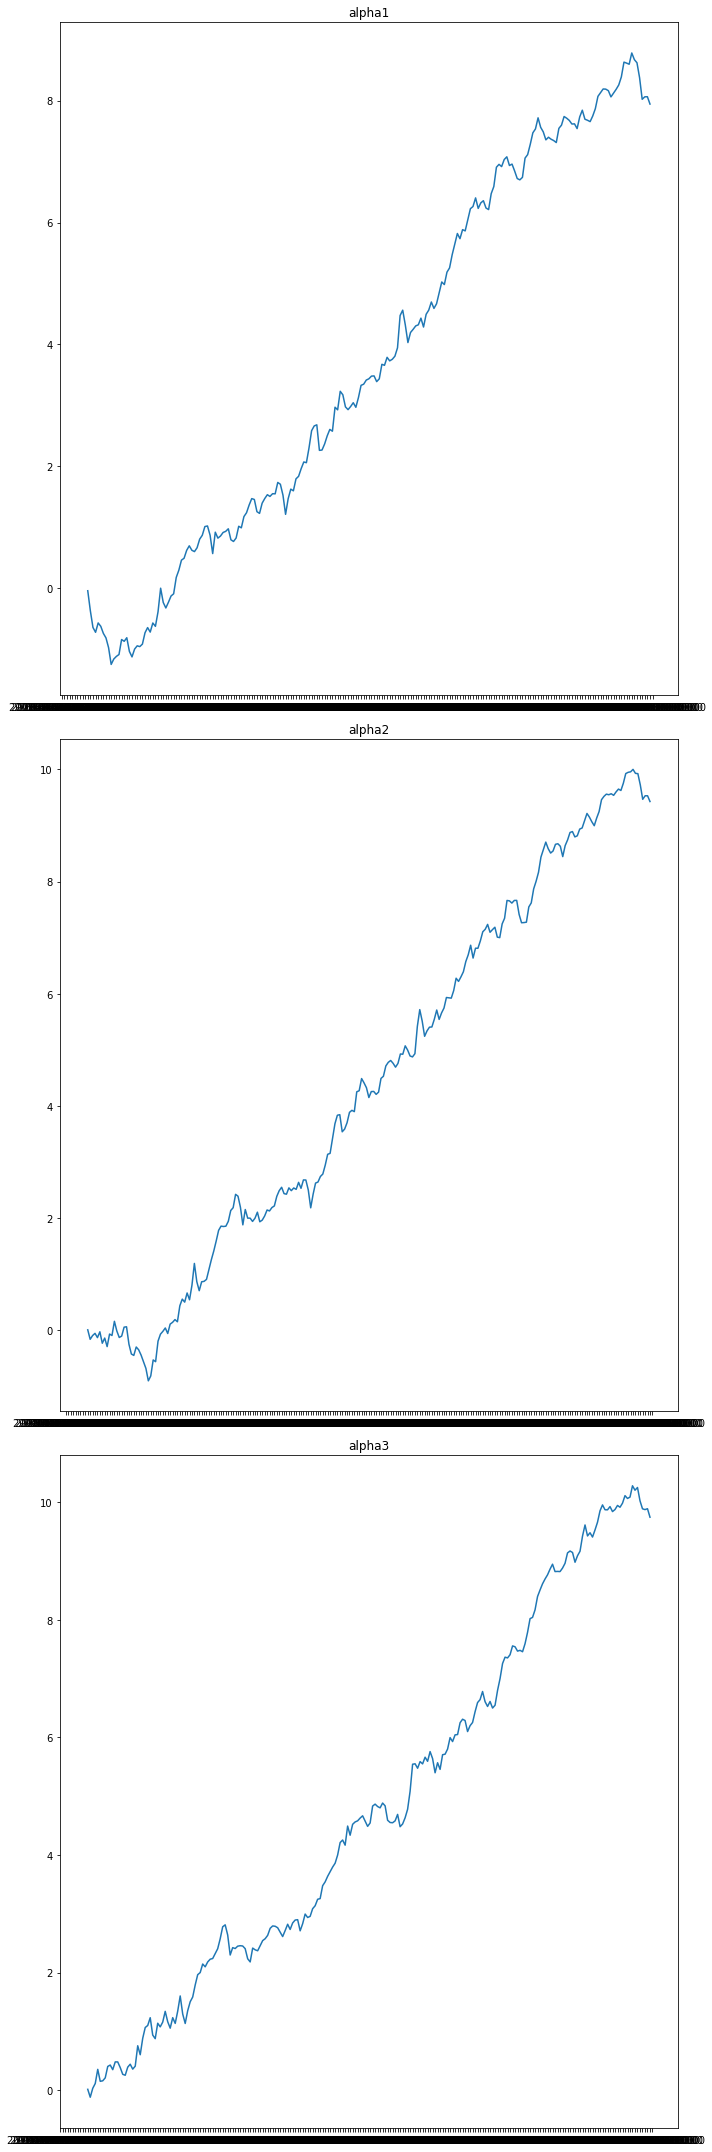

In [22]:
IC=[]
fig, ax = plt.subplots(3, 1, figsize = (10,30))
for i in range(3):
    IC.append(get_IC(i + 1, 'spearman'))
    print('IC of alpha'+str(i + 1), IC[i].describe())
    ax[i].plot(IC[i].cumsum())
    ax[i].set_title('alpha' + str(i + 1))
    plt.tight_layout()

In [23]:
IC_roll=[]
for i in range(3):
    IC_roll.append(IC[i].rolling(3).mean())

In [24]:
ICIR_roll=[]
for i in range(3):
    ICIR_roll.append(IC[i].rolling(3).mean()/IC[i].rolling(3).std())

In [25]:
alpha_eq = (alpha_set[0] + alpha_set[1] + alpha_set[2]) / 3
alpha_ic = alpha_eq[0:1]
for i in range(1,alpha_set[1].shape[0]):
    temp = (alpha_set[0][i:i+1]*IC_roll[0].iloc[i-1] + alpha_set[1][i:i+1]*IC_roll[1].iloc[i-1] + alpha_set[2][i:i+1]*IC_roll[2].iloc[i-1]
           ) / (IC_roll[0].iloc[i-1]+IC_roll[1].iloc[i-1]+IC_roll[2].iloc[i-1]) 
    alpha_ic = pd.concat([alpha_ic,temp],axis=0)

alpha_icir = alpha_eq[0:1]
for i in range(1,alpha_set[1].shape[0]):
    temp = (alpha_set[0][i:i+1]*ICIR_roll[0].iloc[i-1] + alpha_set[1][i:i+1]*ICIR_roll[1].iloc[i-1] + alpha_set[2][i:i+1]*ICIR_roll[2].iloc[i-1] )/(ICIR_roll[0].iloc[i-1]+ICIR_roll[1].iloc[i-1]+ICIR_roll[2].iloc[i-1]) 
    alpha_icir = pd.concat([alpha_icir,temp],axis=0)

In [26]:
alpha_ic = alpha_ic.fillna(0)
alpha_icir = alpha_icir.fillna(0)

In [27]:
alpha_set = []
alpha_set.append(alpha_eq)
alpha_set.append(alpha_ic)
alpha_set.append(alpha_icir)

simulation1 最大回撤： -0.09734999777818287
simulation1 年化收益率 0.6674624168397445
simulation1 Sharpe ratio 3.94113602634665
simulation2 最大回撤： -0.08613758291580764
simulation2 年化收益率 0.643043945159947
simulation2 Sharpe ratio 3.884264384826421
simulation3 最大回撤： -0.09937803699952452
simulation3 年化收益率 0.5741597048384208
simulation3 Sharpe ratio 3.402415878699783


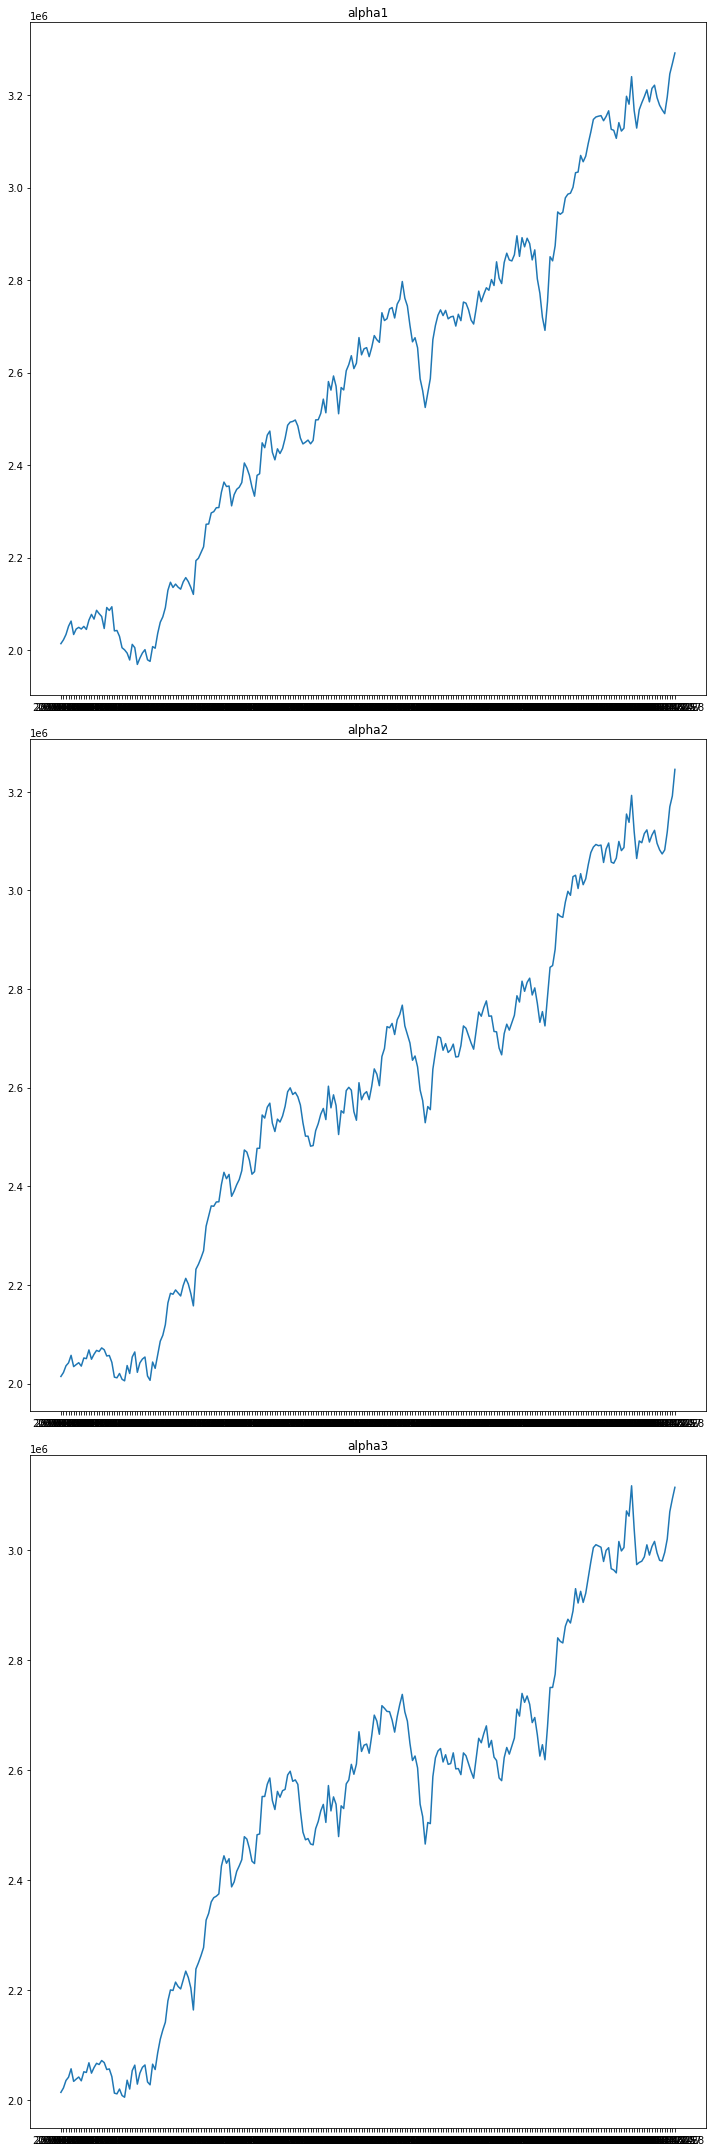

In [28]:
#control the daily turnover in 200%
fig, ax = plt.subplots(3, 1, figsize = (10,30))
list1 = [0,1,2]
for l in range(3):
    k = list1[l]
    money = 1000000
    num = 10
    rate = 0.0015
    pos = []
    index1 = []
    for i in alpha_set[k].index[1:]:
        if int(i[11:13]) == 15 and int(i[14:16]) == 0:
            index1.append(i[:10])
    portfolio = pd.Series(index = index1)
    df_ret=df2['ret'].copy().fillna(0)
    for i in range(198):
        pos.append(money/198)
    for i in alpha_set[k].index[1:]:
        money = 0
        profit = 0

        pre_pos = []
        cur_pos = []


        index_list = list(alpha_set[0].index)
        index_value = index_list.index(i)

        rank_previous=alpha_set[k].iloc[index_value-1].dropna().sort_values()
        for j in range(num):
            pre_pos.append(rank_previous.index[j])
        for j in range(1,num+1):
            pre_pos.append(rank_previous.index[-j])

        rank_current=alpha_set[k].loc[i].dropna().sort_values()
        for j in range(num):
            cur_pos.append(rank_current.index[j])
        for j in range(1,num+1):
            cur_pos.append(rank_current.index[-j])

        inter_num = len(list(set(cur_pos) & set(pre_pos)))


        fee_rate = (2*num-inter_num)/(2*num)


        for j in range(198):
            money += abs(pos[j])*(1-rate*fee_rate)
            profit += pos[j]*(1-rate*fee_rate)*df_ret.loc[i][j]
            pos[j] = 0

        money = money + profit
        rank=alpha_set[k].loc[i].dropna().sort_values()
        for j in range(num):
            pos[rank.index[j]]-=money/(2*num)
        for j in range(1,num+1):
            pos[rank.index[-j]]=money/(2*num)
        portfolio.loc[i[:10]] = money
    

    money = 1000000
    rate = 0.0015
    pos = []
    index1 = []

    for i in alpha_set[k].index[1:]:
        if int(i[11:13]) == 15 and int(i[14:16]) == 0:
            index1.append(i[:10])
    portfolio_2 = pd.Series(index = index1)
    df_ret=df2['ret'].copy().fillna(0)
    for i in range(198):
        pos.append(money/198)
    for i in alpha_set[k].index[1:]:
        money = 0
        profit = 0

        pre_pos = []
        cur_pos = []

        index_list = list(alpha_set[0].index)
        index_value = index_list.index(i)

        rank_previous=alpha_set[k].iloc[index_value-1].dropna().sort_values()
        for j in range(1,num+1):
            pre_pos.append(rank_previous.index[-j])

        rank_current=alpha_set[k].loc[i].dropna().sort_values()
        for j in range(1,num+1):
            cur_pos.append(rank_current.index[-j])

        inter_num = len(list(set(cur_pos) & set(pre_pos)))


        fee_rate = (num-inter_num)/num


        for j in range(198):
            money += abs(pos[j])*(1-rate*fee_rate)
            profit += pos[j]*(1-rate*fee_rate)*df_ret.loc[i][j]
            pos[j] = 0

        money =  profit +money
        
        rank=alpha_set[k].loc[i].dropna().sort_values()
    
        for j in range(1,num+1):
            pos[rank.index[-j]]=money/(num)
        portfolio_2.loc[i[:10]] = money


    portfolio_new = portfolio+portfolio_2
      
    ax[l].plot(portfolio_new)
    ax[l].set_title('alpha' + str(k + 1))
    plt.tight_layout()

    print('simulation' + str(k + 1) + ' 最大回撤：', np.min(portfolio_new / np.maximum.accumulate(portfolio_new) - 1))
    print('simulation' + str(k + 1) + ' 年化收益率', (portfolio_new.iloc[-1]/portfolio_new.iloc[0])**(252/len(portfolio_new.index))-1)
    print('simulation' + str(k + 1) + ' Sharpe ratio',((portfolio_new.iloc[-1]/portfolio_new.iloc[0])**(252/len(portfolio_new.index))-1)/(portfolio_new.pct_change().std()* np.sqrt(252)))


# we can conclude that alpha_ic has the best performance

# out-sample test

In [29]:
data_source = data_test
col = ["open","high","low","close","volume","vwap"]
for x in col:
    data_source[x] = data_source[x].astype(float)
data_source

rand_list = list(set(data_source.trade_symbol))
resampled_data =  []
for i in range(len(rand_list)):
    data_temp = data_source[data_source.trade_symbol == rand_list[i]]
    data_temp.index = range(len(data_temp))
    data_temp_48 = resample(data_temp, 48)
    data_temp_48.index  = data_temp_48.time
    resampled_data.append(data_temp_48)

In [30]:
formula_1 = "tsregres_2d{Close,High,26}"
formula_2 = "tshpf{minus_2d{High,Vwap},10,3}"
formula_3 = "add_2d{tsregres_2d{Vwap,High,17},tsfftimag{neg_2d{Low},19,17}}"

formula_temp_1 = formula_parser.parse(formula_1)
for i in range(len(resampled_data)):
        signal_dataframe = auto_feature(resampled_data[i],formula_temp_1)
        signal_dataframe.index = resampled_data[i].index
        resampled_data[i]['alpha01'] = signal_dataframe

formula_temp_2 = formula_parser.parse(formula_2)
for i in range(len(resampled_data)):
        signal_dataframe = auto_feature(resampled_data[i],formula_temp_2)
        signal_dataframe.index = resampled_data[i].index
        resampled_data[i]['alpha02'] = signal_dataframe

formula_temp_3 = formula_parser.parse(formula_3)
for i in range(len(resampled_data)):
        signal_dataframe = auto_feature(resampled_data[i],formula_temp_3)
        signal_dataframe.index = resampled_data[i].index
        resampled_data[i]['alpha03'] = signal_dataframe

df2 = pd.DataFrame()
for i in range(len(resampled_data)):
    df2 = pd.concat([df2,resampled_data[i]],axis=1)

alpha_set = []
for i in range(3):
    alpha = df2["alpha0"+str(i+1)]
    normalized_alpha = alpha.apply(lambda x: pd.Series(preprocessing.scale(winsorize(x,limits=[0.025, 0.025]))),axis =1)
    alpha_set.append(normalized_alpha)

alpha_set[0]

,0,1,2,3,4,5,6,7,8,9,...,187,188,189,190,191,192,193,194,195,196
time,,,,,,,,,,,,,,,,,,,,,
2019-01-02 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-03 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-04 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-07 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-08 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25 15:00:00,0.723309,-0.542984,-0.004022,1.985508,-0.008618,-0.000861,0.670648,1.059613,0.526615,-0.096904,...,-0.251312,0.101315,-0.324595,-0.319791,-0.623707,-0.122874,0.113275,0.318276,-0.023843,-0.523384
2019-12-26 15:00:00,2.921965,-0.007102,-0.034482,2.921965,0.104054,-0.100002,1.950800,0.008147,0.222085,0.566080,...,-0.383353,-0.118695,0.108443,-0.179804,1.751814,0.092615,0.349784,-0.480847,0.283699,0.389853
2019-12-27 15:00:00,1.030020,-0.042396,-0.457466,-1.032561,-0.333719,-0.423518,0.470496,-0.005213,-0.035788,1.806501,...,-0.346358,-0.865941,0.350606,-0.349502,2.878427,-0.796327,-0.567702,0.819325,-0.439021,-0.036123


# delete the zdt

In [31]:
zdt_list = df2["type"]

In [32]:
from math import nan
for x in range(len(zdt_list)):
    for y in range(len(zdt_list.iloc[x])):
        if zdt_list.iloc[x][y] == 1 or zdt_list.iloc[x][y] == -1:
            alpha_set[0].iloc[x][y]  = nan
            alpha_set[1].iloc[x][y]  = nan
            alpha_set[2].iloc[x][y]  = nan

In [40]:
alpha_set[2]

,0,1,2,3,4,5,6,7,8,9,...,187,188,189,190,191,192,193,194,195,196
time,,,,,,,,,,,,,,,,,,,,,
2019-01-02 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-03 15:00:00,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-04 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-07 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-08 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25 15:00:00,1.014745,-0.857215,0.250366,1.257508,-0.109301,0.280684,0.057775,0.910180,0.613041,-1.619472,...,0.170950,-0.132945,-0.166266,0.129844,-0.892011,-0.541701,0.626651,0.397098,0.098210,-0.619875
2019-12-26 15:00:00,2.020967,-0.704708,0.283257,2.020967,0.057989,0.244372,1.781449,0.183403,0.377902,-2.233077,...,-0.067846,-0.427352,0.839435,0.037221,0.870791,-0.627121,0.949318,-0.146404,0.278674,-0.432051
2019-12-27 15:00:00,1.342034,-0.370497,-0.226418,-1.409547,-0.213877,-0.160991,0.613481,0.065853,-0.027432,0.230843,...,-0.334994,-0.934513,0.696511,-0.332076,1.672441,-1.185298,-0.317392,1.007132,-0.487093,-0.700454


alpha1 最大回撤： -0.0652641873865365
alpha1 年化收益率 0.7561557834288615
alpha1 Sharpe ratio 4.757973466836271
alpha2 最大回撤： -0.06773886016967412
alpha2 年化收益率 0.6208920696291407
alpha2 Sharpe ratio 3.9823415793757806
alpha3 最大回撤： -0.08412097887283787
alpha3 年化收益率 0.4670699675559935
alpha3 Sharpe ratio 3.095112542359516


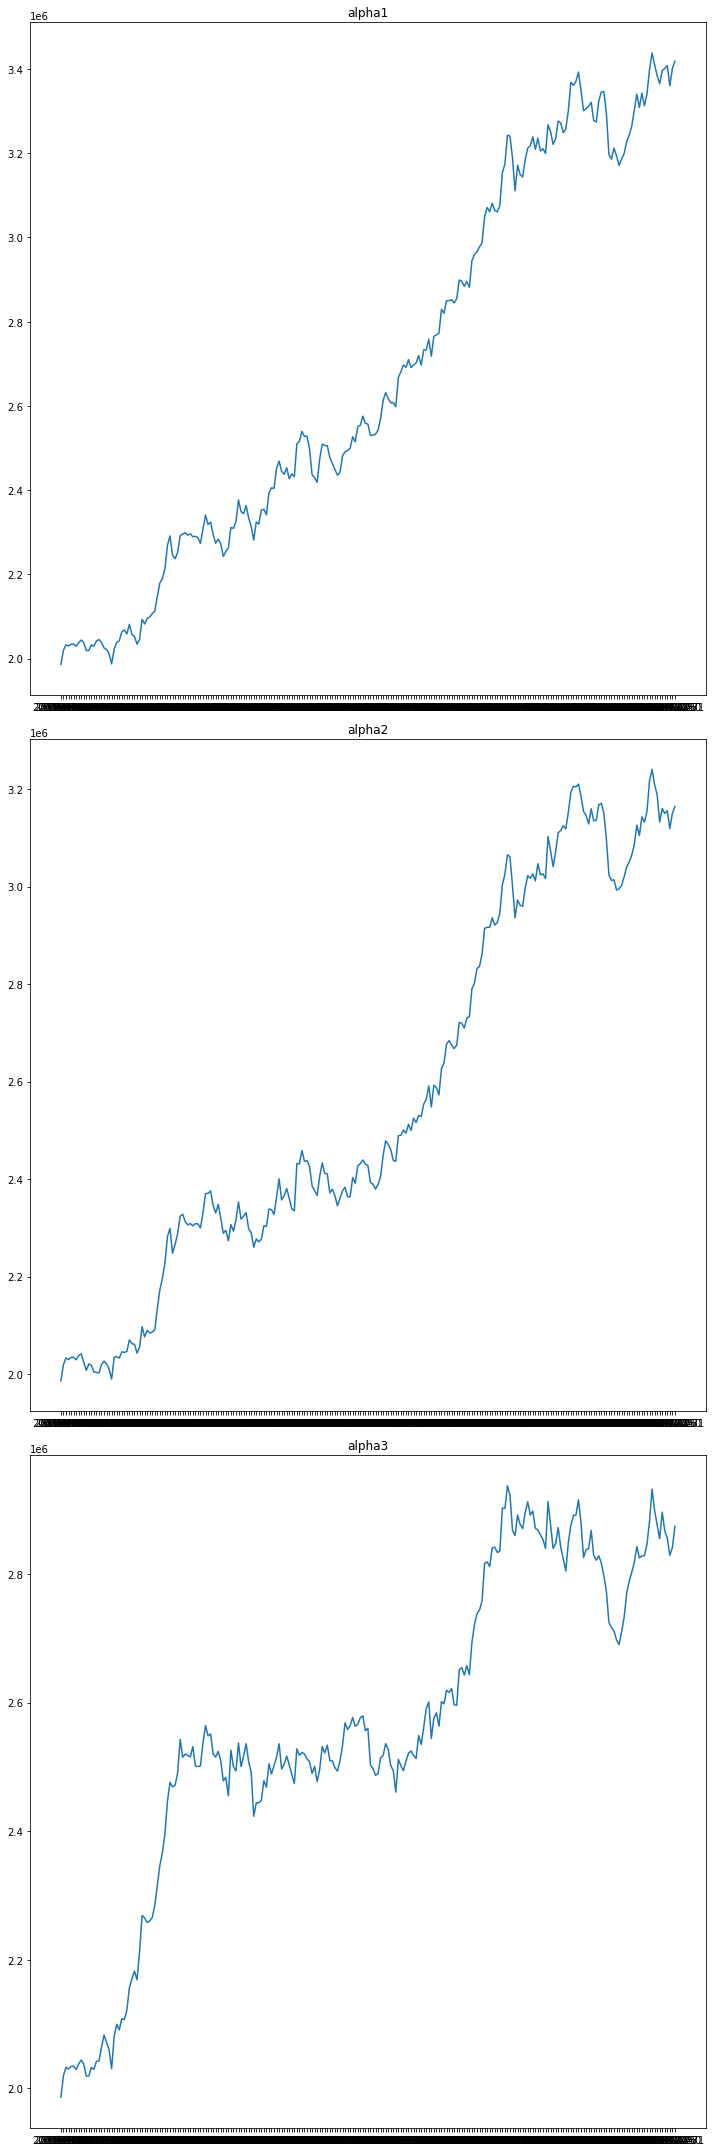

In [42]:
#control the daily turnover in 200%
fig, ax = plt.subplots(3, 1, figsize = (10,30))
list1 = [0,1,2]
for l in range(3):
    k = list1[l]
    money = 1000000
    num = 10
    rate = 0.0015
    pos = []
    index1 = []
    for i in alpha_set[k].index[1:]:
        if int(i[11:13]) == 15 and int(i[14:16]) == 0:
            index1.append(i[:10])
    portfolio = pd.Series(index = index1)
    df_ret=df2['ret'].copy().fillna(0)
    for i in range(197):
        pos.append(money/197)
    for i in alpha_set[k].index[1:]:
        money = 0
        profit = 0

        pre_pos = []
        cur_pos = []


        index_list = list(alpha_set[0].index)
        index_value = index_list.index(i)

        rank_previous=alpha_set[k].iloc[index_value-1].dropna().sort_values()
        for j in range(num):
            pre_pos.append(rank_previous.index[j])
        for j in range(1,num+1):
            pre_pos.append(rank_previous.index[-j])

        rank_current=alpha_set[k].loc[i].dropna().sort_values()
        for j in range(num):
            cur_pos.append(rank_current.index[j])
        for j in range(1,num+1):
            cur_pos.append(rank_current.index[-j])

        inter_num = len(list(set(cur_pos) & set(pre_pos)))


        fee_rate = (2*num-inter_num)/(2*num)


        for j in range(197):
            money += abs(pos[j])*(1-rate*fee_rate)
            profit += pos[j]*(1-rate*fee_rate)*df_ret.loc[i][j]
            pos[j] = 0

        money = money + profit
        rank=alpha_set[k].loc[i].dropna().sort_values()
        for j in range(num):
            pos[rank.index[j]]-=money/(2*num)
        for j in range(1,num+1):
            pos[rank.index[-j]]=money/(2*num)
        portfolio.loc[i[:10]] = money
    

    money = 1000000
    num = 10
    rate = 0.0015
    pos = []
    index1 = []

    for i in alpha_set[k].index[1:]:
        if int(i[11:13]) == 15 and int(i[14:16]) == 0:
            index1.append(i[:10])
    portfolio_2 = pd.Series(index = index1)
    df_ret=df2['ret'].copy().fillna(0)
    for i in range(197):
        pos.append(money/197)
    for i in alpha_set[k].index[1:]:
        money = 0
        profit = 0

        pre_pos = []
        cur_pos = []

        index_list = list(alpha_set[0].index)
        index_value = index_list.index(i)

        rank_previous=alpha_set[k].iloc[index_value-1].dropna().sort_values()
        for j in range(1,num+1):
            pre_pos.append(rank_previous.index[-j])

        rank_current=alpha_set[k].loc[i].dropna().sort_values()
        for j in range(1,num+1):
            cur_pos.append(rank_current.index[-j])

        inter_num = len(list(set(cur_pos) & set(pre_pos)))


        fee_rate = (num-inter_num)/num


        for j in range(197):
            money += abs(pos[j])*(1-rate*fee_rate)
            profit += pos[j]*(1-rate*fee_rate)*df_ret.loc[i][j]
            pos[j] = 0

        money =  profit +money
        
        rank=alpha_set[k].loc[i].dropna().sort_values()
    
        for j in range(1,num+1):
            pos[rank.index[-j]]=money/(num)
        portfolio_2.loc[i[:10]] = money


    portfolio_new = portfolio+portfolio_2
      
    ax[l].plot(portfolio_new)
    ax[l].set_title('alpha' + str(k + 1))
    plt.tight_layout()

    print('alpha' + str(k + 1) + ' 最大回撤：', np.min(portfolio_new / np.maximum.accumulate(portfolio_new) - 1))
    print('alpha' + str(k + 1) + ' 年化收益率', (portfolio_new.iloc[-1]/portfolio_new.iloc[0])**(252/len(portfolio_new.index))-1)
    print('alpha' + str(k + 1) + ' Sharpe ratio',((portfolio_new.iloc[-1]/portfolio_new.iloc[0])**(252/len(portfolio_new.index))-1)/(portfolio_new.pct_change().std()* np.sqrt(252)))


# simulation

IC of alpha1 count    218.000000
mean       0.023573
std        0.104794
min       -0.376759
25%       -0.042666
50%        0.030481
75%        0.094442
max        0.314384
dtype: float64


IC of alpha2 count    234.000000
mean       0.023035
std        0.109704
min       -0.353867
25%       -0.052667
50%        0.017644
75%        0.104202
max        0.308022
dtype: float64
IC of alpha3 count    227.000000
mean       0.031045
std        0.106502
min       -0.364615
25%       -0.032317
50%        0.028235
75%        0.099675
max        0.354472
dtype: float64


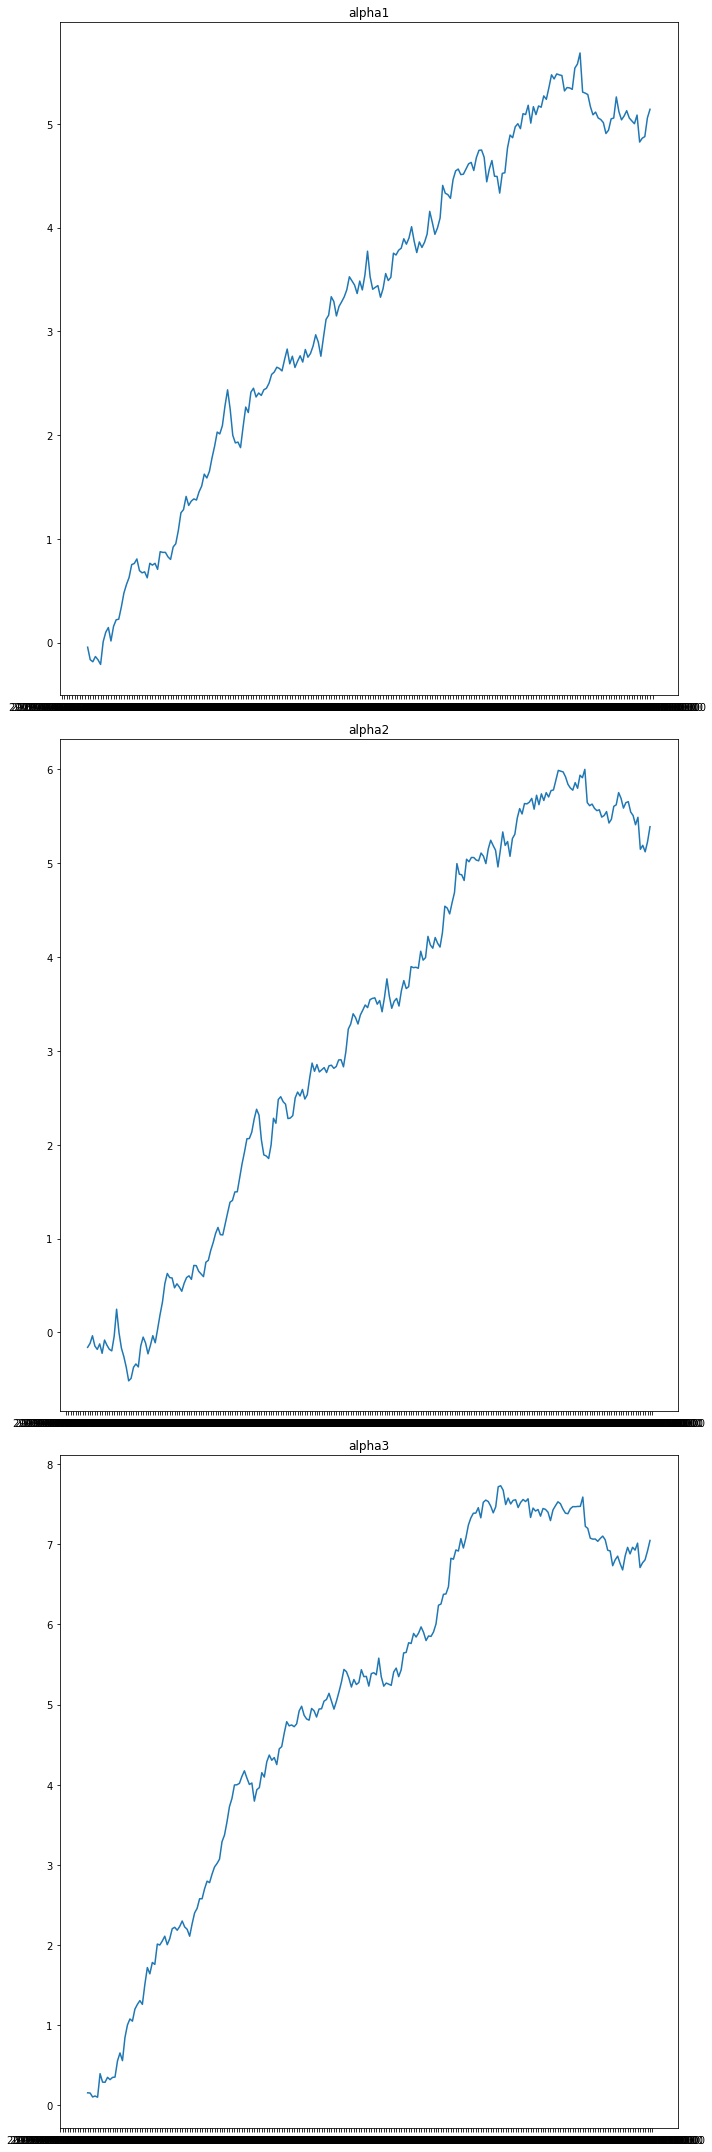

In [43]:
IC=[]
fig, ax = plt.subplots(3, 1, figsize = (10,30))
for i in range(3):
    IC.append(get_IC(i + 1, 'spearman'))
    print('IC of alpha'+str(i + 1), IC[i].describe())
    ax[i].plot(IC[i].cumsum())
    ax[i].set_title('alpha' + str(i + 1))
    plt.tight_layout()

In [44]:
IC_roll=[]
for i in range(3):
    IC_roll.append(IC[i].rolling(3).mean())

In [45]:
alpha_eq = (alpha_set[0] + alpha_set[1] + alpha_set[2]) / 3

alpha_ic = alpha_eq[0:1]
for i in range(1,alpha_set[1].shape[0]):
    temp = (alpha_set[0][i:i+1]*IC_roll[0].iloc[i-1] + alpha_set[1][i:i+1]*IC_roll[1].iloc[i-1] + alpha_set[2][i:i+1]*IC_roll[2].iloc[i-1]
           ) / (IC_roll[0].iloc[i-1]+IC_roll[1].iloc[i-1]+IC_roll[2].iloc[i-1]) 
    alpha_ic = pd.concat([alpha_ic,temp],axis=0)

In [48]:
alpha_eq

,0,1,2,3,4,5,6,7,8,9,...,187,188,189,190,191,192,193,194,195,196
time,,,,,,,,,,,,,,,,,,,,,
2019-01-02 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-03 15:00:00,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-04 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-07 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-08 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25 15:00:00,0.770205,-0.824825,0.102853,1.794818,-0.024635,0.058862,0.280492,0.927069,0.572723,-0.562109,...,-0.069252,-0.097925,-0.317871,-0.335437,-1.097311,-0.224810,0.286046,0.287986,-0.050922,-0.521703
2019-12-26 15:00:00,2.623364,-0.225714,0.039697,2.623364,0.111386,0.002514,2.052787,-0.049901,0.243217,-0.480009,...,-0.153672,-0.290326,0.185136,-0.128330,1.491210,-0.013543,0.544562,-0.365690,0.268743,0.224727
2019-12-27 15:00:00,1.126884,-0.075461,-0.390620,-1.173895,-0.271929,-0.298462,0.506973,0.035044,-0.055148,1.093512,...,-0.282140,-0.865085,0.391100,-0.344488,2.335481,-0.892338,-0.468121,0.922736,-0.453278,-0.305957


simulatuion 最大回撤： -0.04673508186872244
simulatuion 年化收益率 0.4921166441540139
simulatuion Sharpe ratio 3.674485090605533


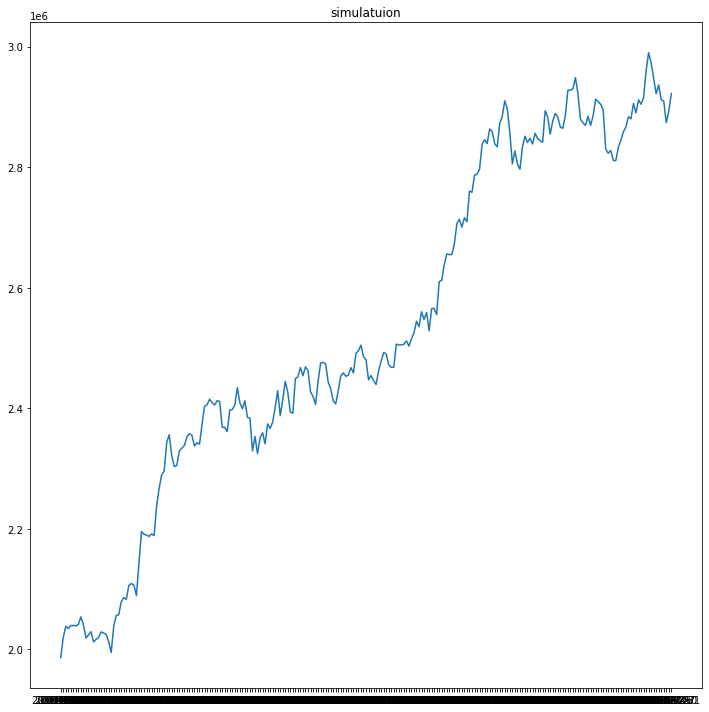

In [49]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))


money = 1000000
num = 20
rate = 0.0015
pos = []
index1 = []
for i in alpha_eq.index[1:]:
    if int(i[11:13]) == 15 and int(i[14:16]) == 0:
        index1.append(i[:10])
portfolio = pd.Series(index = index1)
df_ret=df2['ret'].copy().fillna(0)
for i in range(197):
    pos.append(money/197)
for i in alpha_eq.index[1:]:
    money = 0
    profit = 0

    pre_pos = []
    cur_pos = []


    index_list = list(alpha_set[0].index)
    index_value = index_list.index(i)

    rank_previous=alpha_ic.iloc[index_value-1].dropna().sort_values()
    for j in range(num):
        pre_pos.append(rank_previous.index[j])
    for j in range(1,num+1):
        pre_pos.append(rank_previous.index[-j])

    rank_current=alpha_ic.loc[i].dropna().sort_values()
    for j in range(num):
        cur_pos.append(rank_current.index[j])
    for j in range(1,num+1):
        cur_pos.append(rank_current.index[-j])

    inter_num = len(list(set(cur_pos) & set(pre_pos)))


    fee_rate = ((2*num)-inter_num)/(2*num)


    for j in range(197):
        money += abs(pos[j])*(1-rate*fee_rate)
        profit += pos[j]*(1-rate*fee_rate)*df_ret.loc[i][j]
        pos[j] = 0

    money = money + profit
    rank=alpha_eq.loc[i].dropna().sort_values()
    for j in range(num):
        pos[rank.index[j]]-=money/(2*num)
    for j in range(1,num+1):
        pos[rank.index[-j]]=money/(2*num)
    portfolio.loc[i[:10]] = money


money = 1000000
rate = 0.0015
pos = []
index1 = []

for i in alpha_eq.index[1:]:
    if int(i[11:13]) == 15 and int(i[14:16]) == 0:
        index1.append(i[:10])
portfolio_2 = pd.Series(index = index1)
df_ret=df2['ret'].copy().fillna(0)
for i in range(197):
    pos.append(money/197)
for i in alpha_eq.index[1:]:
    money = 0
    profit = 0

    pre_pos = []
    cur_pos = []

    index_list = list(alpha_set[0].index)
    index_value = index_list.index(i)

    rank_previous=alpha_eq.iloc[index_value-1].dropna().sort_values()
    for j in range(1,num+1):
        pre_pos.append(rank_previous.index[-j])

    rank_current=alpha_eq.loc[i].dropna().sort_values()
    for j in range(1,num+1):
        cur_pos.append(rank_current.index[-j])

    inter_num = len(list(set(cur_pos) & set(pre_pos)))


    fee_rate = (num-inter_num)/num


    for j in range(197):
        money += abs(pos[j])*(1-rate*fee_rate)
        profit += pos[j]*(1-rate*fee_rate)*df_ret.loc[i][j]
        pos[j] = 0

    money =  profit + money
    
    rank=alpha_eq.loc[i].dropna().sort_values()

    for j in range(1,num+1):
        pos[rank.index[-j]]= money/(num)
    portfolio_2.loc[i[:10]] = money


portfolio_new = portfolio+portfolio_2
    
ax.plot(portfolio_new)
ax.set_title('simulatuion')
plt.tight_layout()

print('simulatuion'  + ' 最大回撤：', np.min(portfolio_new / np.maximum.accumulate(portfolio_new) - 1))
print('simulatuion' +' 年化收益率', (portfolio_new.iloc[-1]/portfolio_new.iloc[0])**(252/len(portfolio_new.index))-1)
print('simulatuion' + ' Sharpe ratio',((portfolio_new.iloc[-1]/portfolio_new.iloc[0])**(252/len(portfolio_new.index))-1)/(portfolio_new.pct_change().std()* np.sqrt(252)))
